# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [ ]:
# données
data = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/TP6_IARN/data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données.

Mettons ces données dans leus vecteurs correspondants.

In [ ]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [ ]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

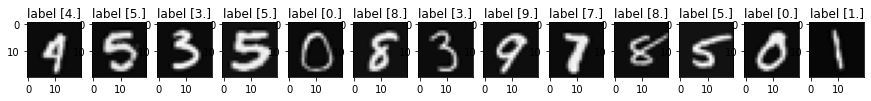

In [ ]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [ ]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [ ]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [ ]:
# poids de la couche 1
W1 = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/TP6_IARN/W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [ ]:
# poids de la couche 2
W2 = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/TP6_IARN/W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [ ]:
input_layer_size  = 400;
hidden_layer_size = 25;
num_labels = 10;

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [ ]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z))

In [ ]:
# retourne la valeur du cout sans régularisation
def computeCost(X, YY, theta1, theta2,hidden_layer_size):
    epsilon = 1e-15 # j'ajoute ce terme à la fonction Log afin d'éviter d'avoir des overflows par la suite
    a1=X

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size))

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1))))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))
    a3= np.zeros((YY.shape[0],YY.shape[1]))

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)

    J=np.zeros((YY.shape[0],1))
    J= (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(a3 + epsilon))-((1-YY)*np.log(1-a3 + epsilon)))))
    return J

# retourne la valeur du cout avec régularisations
def computeCostReg(X, YY, theta1, theta2,hidden_layer_size, lambda_):
  J = computeCost(X, YY, theta1, theta2,hidden_layer_size) # cout sans régularisation
  # avec régularisation
  val1 = np.sum(np.sum(np.square(theta1)))
  val2 = np.sum(np.sum(np.square(theta2)))
  reg = (lambda_ /2*y.shape[0])*(val1 + val2)
  J = J + reg
  return J

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [ ]:
def NNCostFunction(X, YY, theta1, theta2):
    grad1 = np.zeros((theta1.shape[1], theta1.shape[0]))
    grad2 = np.zeros((theta2.shape[1],theta2.shape[0]))

    m = len(X) # nombre d'exemples

    # forward_propagation
    z1 = np.zeros((len(X), len(theta1)))
    z1 = X.dot(theta1.T)
    a1 = Sigmoid(z1)
    intercept = np.ones((len(X), 1))
    a1 = np.column_stack((intercept, a1))
    z2 = np.zeros((len(X), len(W2)))
    z2 = a1.dot(W2.T)
    a2 = Sigmoid(z2)

    for i in range(m):
      yy = YY[i, :]

      dz2 = a2 - yy
      dz1 = dz2.dot(theta2) * (a1*(1 - a1))
      end = theta2.shape[1]
      dz1 = dz1[:, 1: end]

      grad1 = grad1 + X.T.dot(dz1)
      grad2 = grad2 + a1.T.dot(dz2)

    grad1 = grad1/m
    grad2 = grad2/m

    grad = {
        'grad1' : grad1,
        'grad2' : grad2
    }
    return grad

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [ ]:
def gradientDescent(X, y, theta1, theta2, alpha, iterations, hidden_layer_size, lambda_):
    cout = [] # garder le cout à chaque itération
    grad = NNCostFunction(X, YY, theta1, theta2)
    grad1 = grad['grad1']
    grad2 = grad['grad2']
    for i in range(iterations):
      cout.append(computeCostReg(X, YY, theta1, theta2,hidden_layer_size, lambda_))
      theta1 = theta1 - np.dot(alpha, grad1.T)
      theta2 = theta2 - np.dot(alpha, grad2.T)
    theta = {
        'theta1' : theta1,
        'theta2' : theta2
    }
    return theta, cout


# TODO 4 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [ ]:
# appliquer une propagation vers l'avant
def forward_propagation(W1, W2, X):
 #----------------- Couche 1 -------------------------------
    # calcule du z1
    z1 = np.zeros((len(X), len(W1)))
    z1 = X.dot(W1.T)
    a1 = Sigmoid(z1) # appliquer la sigmoid (activation de z1)
    intercept = np.ones((len(X), 1))
    a1 = np.column_stack((intercept, a1)) # ajouter une column à a1

    #----------------- Couche 2 -------------------------------
    # calcule du z2
    z2 = np.zeros((len(X), len(W2)))
    z2 = a1.dot(W2.T)
    a2 = Sigmoid(z2) # appliquer la sigmoid (activation de z2)

    # retourner un dictionnaire contenant toutes nos activations
    activations = {
        'a1' : a1,
        'a2' : a2
    }
    return activations


# prediction
def predict (W1, W2, X):
    activations = forward_propagation(W1, W2, X)
    a2 = activations['a2']
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
    y_pred = np.zeros((len(a2), 1))
    for i in range(a2.shape[0]):
      y_pred[i, 0] = np.argmax(a2[i, :]) +1
      y_pred = np.where(y_pred==10, 0, y_pred)
    return y_pred

#Appels des fonctions

⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛
 ps: j'avais obtenue plusieurs warnings, les deux premier était du à la fonction Log, je l'ai régler en ajoutant un terme epsilon à la fonction log, le troisième par contre est du à la fonction exp, du coup j'ai essayer de le régler en normalisons nos données X (Normalisation MinMax) mais ça n'avait pas l'air de marcher :( ....

⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛

In [ ]:
# normaliser nos données afin d'éviter les overflow
X = (X - X.min())/(X.max() - X.min())

# cout initiale
# sans régularisation
J = computeCost(X, YY, W1, W2,hidden_layer_size)
print("cout initiale sans régularisation : "+str(J))

# avec régularisation
lambda_ = 1
J = computeCostReg(X, YY, W1, W2,hidden_layer_size, lambda_)
print("cout initiale avec régularisation : "+str(J))

cout initiale sans régularisation : 8.758495009561255
cout initiale avec régularisation : 2421469.875163097


In [ ]:
# paramètres
iterations = 1500;
alpha = 0.01;
theta_final, cout = gradientDescent(X, y, W1, W2, alpha, iterations, hidden_layer_size, lambda_)
W11 = theta_final['theta1']
W22 = theta_final['theta2']
print('shape')
print('W11 '+str(W11.shape))
print('W22 '+str(W22.shape))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


shape
W11 (25, 401)
W22 (10, 26)


In [ ]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(W11, W22, X)
precision = np.mean(y==y_pred)*100
print("----------------------------------------")
print("precision : "+str(precision))
print("----------------------------------------")
print()

----------------------------------------
precision : 10.0
----------------------------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛
Normalement la valeur de la précision devrait etre beaucoup plus grande, mais ce n'est pas le cas içi, vous verez dans la suite que meme avec la librairie sklearn on obtient la meme valeur, donc je pense que c'est du au fait que je travaille avec les ancienes étiquettes (ps: je n'ai pas modifier les étiquettes) :( ....

⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛

In [ ]:
# cout final
# sans régularisation
J = computeCost(X, YY, W11, W22,hidden_layer_size)
print("cout final sans régularisation : "+str(J))

# avec régularisation
lambda_ = 1
J = computeCostReg(X, YY, W11, W22,hidden_layer_size, lambda_)
print("----------------------------------------")
print("cout final avec régularisation : "+str(J))
print("----------------------------------------")

cout final sans régularisation : 200.86370800224256
----------------------------------------
cout final avec régularisation : 11793970363171.53
----------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


traçage du cout en fonction du nombre d'itérations

Text(0, 0.5, 'coût')

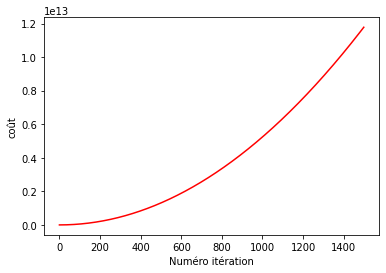

In [ ]:
plt.plot(range(1500), cout, c='r')
plt.xlabel('Numéro itération')
plt.ylabel('coût')

⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛
encore un autre problème inquiétant, içi la valeur du cout augmente aprés chaque itération :(  ....

⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
#entrainement
model.fit(X[:, 1:401], y.ravel())
#prediction
y_predict = model.predict(X[:, 1:401])
precision = np.mean(y==y_pred)*100
print()
print("precision avec sklearn : "+str(precision))


precision avec sklearn : 10.0


⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛
nous voyons bien que meme avec la librairie sklearn la valeur de la précision est == 10, alors on pourras dire que l'erreur n'est pas forcément du à mon code  :(  ....

⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛⚛

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 .
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)